<a href="https://colab.research.google.com/github/fedassembly/tensorflow-cert-prep/blob/main/04_Transfer_Learning_in_TensorFlow_Part_1_Feature_Extraction_Exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?


In [1]:
!rm -rf /content/10_food_classes_10_percent.zip /content/10_food_classes_10_percent /content/__MACOSX
!wget -q -P /content https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
!unzip -q 10_food_classes_10_percent.zip -d /content
!rm -rf /content/__MACOSX

In [2]:
from pathlib import Path
import os

p = Path("/content/10_food_classes_10_percent")
class_names = os.listdir(str(p) + "/train")
class_counts = {"train": dict.fromkeys(class_names, 0), "test": dict.fromkeys(class_names, 0)}
for i in p.glob("**/*.jp*g"):
  class_counts[i.parent.parent.name][i.parent.name] += 1
class_counts

{'train': {'sushi': 75,
  'hamburger': 75,
  'ramen': 75,
  'grilled_salmon': 75,
  'pizza': 75,
  'ice_cream': 75,
  'fried_rice': 75,
  'chicken_wings': 75,
  'steak': 75,
  'chicken_curry': 75},
 'test': {'sushi': 250,
  'hamburger': 250,
  'ramen': 250,
  'grilled_salmon': 250,
  'pizza': 250,
  'ice_cream': 250,
  'fried_rice': 250,
  'chicken_wings': 250,
  'steak': 250,
  'chicken_curry': 250}}

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds, val_ds = image_dataset_from_directory(
    str(p) + "/train",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="both",
)

Found 750 files belonging to 10 classes.
Using 600 files for training.
Using 150 files for validation.


In [4]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Rescaling, Dense
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

def create_tb_callback(model_name: str) -> None:
  log_dir = f"./logs/{model_name}"
  return TensorBoard(log_dir)

def create_model(model_name: str, pretrained_url: str, n_classes: int = 10) -> None:
  model = Sequential([
      Rescaling(1./255., input_shape=(224, 224, 3)),
      hub.KerasLayer(pretrained_url),
      Dense(n_classes, activation="softmax")
  ], name=model_name)
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  model.summary()
  return model

In [5]:
inception = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"                 # input range [0,1] of size 299 x 299 (but similar is fine)
resnet = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"                    # input range [0,1] of size 224 x 224
bit = "https://tfhub.dev/google/bit/m-r50x1/1"                                                # input range [0,1] of size 224 x 224
nasnet = "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5"                   # input range [0,1] of size 224 x 224
effnet1 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"                     # input range [0,1] of size 224 x 224
mobnet = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"            # input range [0,1] of size 224 x 224
effnet2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2" # input range [0,1] of size 224 x 224

experiments = [
    ("Inception_V3", inception),
    ("ResNet50_V2", resnet),
    ("BiT_ResNet50", bit),
    ("NASNet_Mobile", nasnet),
    ("EfficientNetB0_V1", effnet1),
    ("MobileNet_V2", mobnet),
    ("EfficientNetB0_V2", effnet2),
]

for e in experiments:
  model = create_model(*e)
  model.fit(train_ds,
            epochs=10,
            validation_data=val_ds,
            validation_steps=len(val_ds),
            callbacks=[create_tb_callback(model.name)]
            )

Model: "Inception_V3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 22s 308ms/step - loss: 1.8463 - accuracy: 0.3983 - val_loss: 1.1469 - val_accuracy: 0.6267
Epoch 2/10
19/19 [==============================] - 2s 92ms/step - loss: 0.9657 - accuracy: 0.7183 - val_loss: 0.9067 - val_accura

In [6]:
%load_ext tensorboard
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

2. Name 3 different image classification models on TensorFlow Hub that we haven't used.


- InceptionNet/GoogleNet V1 - "Going deeper with convolutions", 2014

https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5

- InceptionNet/GoogleNet V3 - "Rethinking the Inception Architecture for Computer Vision", 2015

https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5

- NASNet - "Neural Architecture Search with Reinforcement Learning", 2017.

https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/5

- Big Transfer (BiT) - "Big Transfer (BiT): General Visual Representation Learning", 2019

https://tfhub.dev/google/bit/m-r50x1/1 (r50x1 mean based on ResNet50 1 times wider)

3. Build a model to classify images of two different things you've taken photos of.
  * You can use any feature extraction layer from TensorFlow Hub you like for this.
  * You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.


In [7]:
!rm -rf /content/images/
!mkdir -p /content/images/{guitar,drums,trumpet}
!wget -q -P /content/images/guitar \
 'https://static.toiimg.com/thumb/msid-86937496,width-1280,resizemode-4/86937496.jpg' \
 'https://assets.yousician.com/app/uploads/2021/02/15152144/learn-guitar-1-1000x1000.jpg' \
 'https://www.insure4music.co.uk/media/p14mt4xo/istock-1056444080.jpg' \
 'https://assets.yousician.com/app/uploads/2022/05/05130122/yousician-educational-photography-21-1024x683.jpg' \
 'https://cdn.shopify.com/s/files/1/0058/9873/1587/products/DSC2496-Edit___20191001_1024x1024.jpg' \
 'https://pocketmagscovers.imgix.net/guitar-player-magazine-march-2023-cover.jpg' \
 'https://www.thoughtco.com/thmb/OjaF_zxzYbnoncdfXtV5JE_PBy4=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-186459142-5c251e3946e0fb0001d607a4.jpg' \
 'https://upload.wikimedia.org/wikipedia/commons/3/37/Steel_guitar.jpg' \
 'https://static01.nyt.com/images/2020/09/08/fashion/08guitar-taylor-swift/08guitar-taylor-swift-mediumSquareAt3X-v2.jpg' \
 'https://i.ytimg.com/vi/e26zZ83Oh6Y/maxresdefault.jpg' \
 'https://www.native-instruments.com/typo3temp/pics/img-welcome-hero-guitar-rig-6-player-product-page-01-hero-v2-8c04bb712c562230a837e56511c10f1d-m@2x.jpg' \
 'https://i0.wp.com/acousticguitar.com/wp-content/uploads/2022/03/biz-card-under-strings-e1646432233815.jpg' \
 'https://www.expertreviews.co.uk/sites/expertreviews/files/2018/04/electricguitardude_0.jpg' \
 'https://i.ytimg.com/vi/Anop2dCuR2g/maxresdefault.jpg' \
 'https://cdn.shopify.com/s/files/1/1434/2352/t/11/assets/slideshow_4_1200x.jpg' \
 'https://www.ibanez.com/eu/news_file/file/fp_ichikapick.jpg'
!wget -q -P /content/images/drums \
 'https://storage.googleapis.com/stateless-blog-g4m-co-uk/2023/03/Featured-image-best-drum-set-brands.jpg' \
 'https://images.squarespace-cdn.com/content/v1/55524b6ce4b02fc9d3e73f42/0928aa64-30b4-4c91-91f5-7d6c696f47df/stock-24.jpg' \
 'https://schoolofrock.imgix.net/img/news-article-hero-750w/beginning-drums2-1645469645.jpg' \
 'https://i.ytimg.com/vi/XP98nr6qOw4/maxresdefault.jpg' \
 'https://cdn.shopify.com/s/files/1/0970/0050/files/image4_bd4316cb-ffb4-4f2f-b044-2a5881c17f88.jpg' \
 'https://cdn.musichouseschool.com/KidHandsPlayingDrumswithSoundPads.jpg' \
 'https://post.medicalnewstoday.com/wp-content/uploads/sites/3/2020/01/327279_1100-1100x628.jpg' \
 'https://www.protoolreviews.com/wp-content/uploads/2023/03/Yamaha-DTX6-Electronic-Drums.jpg' \
 'https://www.datocms-assets.com/17746/1603354938-drum3.jpg' \
 'https://www.allianz.co.uk/personal-insurance/musical-insurance/drums-and-percussion/_jcr_content/root/stage/stageimage.img.82.3360.jpeg/1605883186325/drums-stage-desktop-girl.jpeg' \
 'https://images.squarespace-cdn.com/content/v1/57f66a16e4fcb5154dc8ba39/d78b2199-f60e-4e35-9c89-96f66fb05f0b/unsplash-image-JAIwTWU4lVU.jpg' \
 'https://www.icmp.ac.uk/sites/default/files/styles/news_details/public/jon_harris_icmp_profile__0.jpg' \
 'https://stevenslatedrums.com/wp-content/uploads/2020/03/SSD-5.5-Kit-Edit-Window-web.jpeg' \
 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/Visulite.jpg/640px-Visulite.jpg' \
 'https://d3stsh1547n2ng.cloudfront.net/banner/poster.jpg' \
 'https://assets.xlnaudio.com/pages/addictive_drums/new/Hero-Modern-Soul-800px.jpg'
!wget -q -P /content/images/trumpet \
 'https://i.ytimg.com/vi/LpHx7xKOEpM/maxresdefault.jpg' \
 'https://www.musicalhow.com/wp-content/uploads/featured-types-trumpets.jpg' \
 'https://media.npr.org/assets/img/2022/12/22/im1-dca4c5d9cfca82484dcffe869df9f19929337f1e.jpg' \
 'https://www.rollingstone.com/wp-content/uploads/2020/09/GettyImages-96410285.jpg' \
 'https://assets.classicfm.com/2017/01/trumpet-v4r-1483624906-editorial-long-form-0.jpg' \
 'https://media.gq-magazine.co.uk/photos/5d13a0e458bc1c415cface8b/4:3/w_1704,h_1278,c_limit/Miles-Davis-GQ-22Aug16_getty_b.jpg' \
 'https://mynewmicrophone.com/wp-content/uploads/2022/01/mnm_Top_11_Benefits_Of_Learning__Playing_Trumpet_large.jpg' \
 'https://middermusic.com/wp-content/uploads/2021/07/best-online-trumpet-lessons.jpg' \
 'https://files.ekmcdn.com/stgilesmusic/images/boosey-hawkes-trumpet-sold-10384-p.jpg' \
 'https://ichef.bbci.co.uk/images/ic/480xn/p08b2wnl.jpg' \
 'https://images.immediate.co.uk/production/volatile/sites/24/2022/10/trumpet-guide-f931134.jpg' \
 'https://tf-cmsv2-smithsonianmag-media.s3.amazonaws.com/filer/20/59/20593506-ce49-4ba7-958b-db1ba490f2d3/dizzy_gillespie_giants_of_jazz_1973_dia0006.jpg' \
 'https://hellomusictheory.com/wp-content/uploads/2021/09/Louis-Armstrong.jpeg' \
 'https://www.tutoring-blog.co.uk/wp-content/uploads/2023/05/trumpet-scaled.jpg' \
 'https://b2380825.smushcdn.com/2380825/wp-content/uploads/2016/04/tromhome1-scaled.jpg' \
 'https://cdn.shopify.com/s/files/1/0557/0556/7432/articles/AdobeStock_90220878_46a10700-6fe3-4bb1-a16a-049da574633e.jpg'
!cd /content/images/guitar && ls -v | cat -n | while read n f; do mv -n "$f" `printf "%02d.jpg" $n`; done
!cd /content/images/drums && ls -v | cat -n | while read n f; do mv -n "$f" `printf "%02d.jpg" $n`; done
!cd /content/images/trumpet && ls -v | cat -n | while read n f; do mv -n "$f" `printf "%02d.jpg" $n`; done

In [8]:
class_names = ["guitar", "drums", "trumpet"]
train_ds, val_ds = image_dataset_from_directory(
    "/content/images/",
    labels="inferred",
    label_mode="categorical",
    class_names=class_names,
    batch_size=4,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="both",
    crop_to_aspect_ratio=False,
)
effnet1 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
model = create_model("EfficientNetB0_V1", effnet1, len(class_names))
model.fit(train_ds,
          epochs=5,
          validation_data=val_ds,
          validation_steps=len(val_ds)
          )

Found 46 files belonging to 3 classes.
Using 37 files for training.
Using 9 files for validation.
Model: "EfficientNetB0_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer_7 (KerasLayer)  (None, 1280)              4049564   
                                                                 
 dense_7 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 4053407 (15.46 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________
Epoch 1/5
10/10 [==============================] - 12s 190ms/step - loss: 1.0503 - accuracy: 0.3784 - val_loss: 0.6998 - val_accuracy: 0.8889
Epoch 2/5
10/10 [==============

1/1 [==============================] - 1s 926ms/step


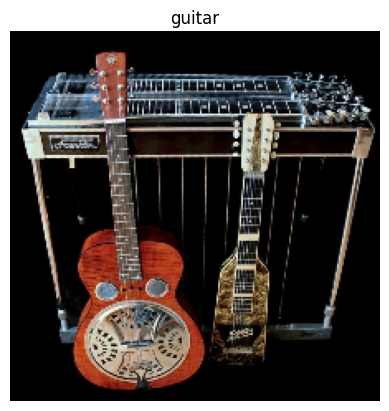

In [9]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

files = []
p = Path("/content/images/")
for i in p.glob("**/*.jpg"):
     files.append(i)

f = random.choice(files)
img = tf.io.read_file(str(f))
img = tf.image.decode_image(img, channels=3)
img = tf.image.resize(img, size=(model.input_shape[1], model.input_shape[2]))
img = tf.expand_dims(img, axis=0)
pred = model.predict(img)
plt.imshow(img[0].numpy().astype("uint8"))
plt.axis("off")
plt.title(train_ds.class_names[tf.argmax(pred, axis=1)[0]])
plt.show()

4. What is the current best performing model on ImageNet?
  * Hint: you might want to check [sotabench.com](https://www.sotabench.com) for this.

The absolute top performing is BASIC-L with Lion optimizer (2440M parameters) with a top-1 accuracy of 91.1%. But Meta Pseudo Labels (based on EfficientNet-L2) has a top-1 accuracy of 90.2% and only 480M parameters.